# Exploratory Part

### What we'll do here
- Set up the environment and imports
- Load cluster outputs from the prediction part
- Aggregate pickups and prepare weather/holiday/event features
- Split train/test and explore demand patterns
- Train baseline and improved random forest models
- Evaluate and visualize results citywide and by cluster

### How to run
1. Make sure you have the data in the data folder
2. Then run each subsequent step top-to-bottom.

### Table of Contents
- [3.1 Imports](#31-imports)
- [3.2 Load data and clusters](#32-load-data-and-clusters)
- [3.3 Hourly pickups by cluster](#33-hourly-pickups-by-cluster)
- [3.4 Add weather, holidays, events](#34-add-weather-holidays-events)
- [3.5 Train/test split Jan-Oct vs Nov-Dec](#35-traintest-split-jan-oct-vs-nov-dec)
- [3.6 Explore drivers vs pickups](#36-explore-drivers-vs-pickups)
- [3.7 Game-day uplift vs nearby non-game days](#37-game-day-uplift-vs-nearby-non-game-days)
- [3.8 RF feature importance](#38-rf-feature-importance)
- [3.9 Baseline RF predictions](#39-baseline-rf-predictions)
- [3.10 Enhanced RF with exogenous features](#310-enhanced-rf-with-exogenous-features)
- [3.11 Quantify improvements](#311-quantify-improvements)
- [3.12 Use KMeans clusters](#312-use-kmeans-clusters)
- [3.13 Cluster 0 vs 6 runs](#313-cluster-0-vs-6-runs)
- [3.14 Cluster-level metrics](#314-cluster-level-metrics)

### 3.1 Imports

Load the libraries and helpers used for the exploratory analysis.


### 3.1 Imports

Load the libraries and helpers used for the exploratory analysis.

In [55]:
# Core libraries for data prep, modeling, and plotting.
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import calendar


### 3.2 Load data and clusters

Bring in the ride data and the cluster assignments produced in the prediction notebook.

In [56]:
# Paths to inputs and cluster map from prediction step.
trips_path = Path("../data/trips_2018.csv")
weather_path = Path("../data/weather_2018_nyc_hourly.csv")
holidays_path = Path("../data/us_holidays_2004_2021.csv")
nba_path = Path("../data/nba_games.csv")
cluster_map_path = Path("../Prediction-Part/TABLES/cluster_map.csv")

if not cluster_map_path.exists():
    raise FileNotFoundError("cluster_map.csv missing; run prediction-part notebook to create it.")

# Map station ids to cluster ids for later joins.
cluster_map = pd.read_csv(cluster_map_path)
cluster_lookup = dict(zip(cluster_map["station_id"].astype("Int32"), cluster_map["cluster_id"].astype(int)))

NYC_TEAMS = {1610612752: "knicks", 1610612751: "nets"}
TEAM_CLUSTER = {"knicks": 19, "nets": 23}


### 3.3 Hourly pickups by cluster

Summarize pickups per hour for each cluster to understand temporal demand.

In [57]:
# Stream trip CSV in chunks and count pickups by hour/cluster.

def aggregate_hourly_pickups():
    counter = Counter()
    for chunk in pd.read_csv(
        trips_path,
        usecols=["starttime", "start_station_id"],
        chunksize=400_000,
        low_memory=True,
    ):
        # Floor to hour, map to cluster, and tally counts.
        chunk["ts"] = pd.to_datetime(chunk["starttime"], errors="coerce").dt.floor("H")
        chunk = chunk.dropna(subset=["ts", "start_station_id"])
        chunk["cluster_id"] = chunk["start_station_id"].astype("Int32").map(cluster_lookup)
        m = chunk["cluster_id"].notna()
        if not m.any():
            continue
        vc = chunk.loc[m].groupby(["ts", "cluster_id"]).size()
        for (ts, cid), cnt in vc.items():
            counter[(ts, int(cid))] += int(cnt)

    df = pd.DataFrame(
        [(ts, cid, cnt) for (ts, cid), cnt in counter.items()],
        columns=["ts", "cluster_id", "pickups"],
    )
    return df.sort_values(["ts", "cluster_id"]).reset_index(drop=True)

# Assemble hourly cluster table and citywide totals.
df_hourly = aggregate_hourly_pickups()
df_hourly["date"] = df_hourly["ts"].dt.date
df_hourly["hour"] = df_hourly["ts"].dt.hour

citywide = (
    df_hourly.groupby("ts")["pickups"]
    .sum()
    .rename("trips_total")
    .reset_index()
)

print("Hourly rows:", len(df_hourly), "| citywide hours:", len(citywide))


Hourly rows: 175482 | citywide hours: 8743


### 3.4 Add weather, holidays, events

Merge in weather, holiday, and NBA game info so we can see how events and conditions relate to demand.

In [58]:
# Load weather data and resample to hourly.
weather_raw = pd.read_csv(weather_path)
weather_raw["ts"] = pd.to_datetime(weather_raw["time"], errors="coerce")
weather = weather_raw[weather_raw["ts"].dt.year == 2018].copy()
weather = weather.rename(columns={
    "temperature_2m (°C)": "temp_C",
    "precipitation (mm)": "precip_mm",
    "rain (mm)": "rain_mm",
    "cloudcover (%)": "cloudcover",
    "windspeed_10m (km/h)": "wind_kph",
})
weather = (
    weather[["ts", "temp_C", "precip_mm", "rain_mm", "cloudcover", "wind_kph"]]
    .set_index("ts")
    .sort_index()
    .resample("H")
    .ffill()
    .reset_index()
)

# Attach holidays and game-night flags to citywide demand.
holidays = pd.read_csv(holidays_path)
holidays["date"] = pd.to_datetime(holidays["Date"], errors="coerce").dt.date
holidays_2018 = holidays[holidays["date"].apply(lambda d: getattr(d, "year", 0) == 2018)][["date", "Holiday"]]
holidays_2018["is_holiday"] = 1

nba = pd.read_csv(nba_path)
nba["date"] = pd.to_datetime(nba["GAME_DATE_EST"], errors="coerce").dt.date
nba_home = nba[nba["TEAM_ID_home"].isin(NYC_TEAMS.keys())].copy()
nba_home = nba_home[nba_home["date"].apply(lambda d: getattr(d, "year", 0) == 2018)]

team_game_dates = {
    NYC_TEAMS[tid]: set(nba_home.loc[nba_home["TEAM_ID_home"] == tid, "date"].dropna())
    for tid in NYC_TEAMS
}

data = citywide.merge(weather, on="ts", how="left")
data["date"] = data["ts"].dt.date
data["dow"] = data["ts"].dt.dayofweek.astype("int8")
data["hour_of_day"] = data["ts"].dt.hour.astype("int8")
data["month"] = data["ts"].dt.month.astype("int8")
data["is_weekend"] = (data["dow"] >= 5).astype("int8")

data = data.merge(holidays_2018[["date", "is_holiday"]], on="date", how="left")
data["is_holiday"] = data["is_holiday"].fillna(0).astype("int8")

data["is_knicks_evening"] = (
    data["date"].isin(team_game_dates.get("knicks", set()))
    & data["hour_of_day"].between(18, 23)
).astype("int8")
data["is_nets_evening"] = (
    data["date"].isin(team_game_dates.get("nets", set()))
    & data["hour_of_day"].between(18, 23)
).astype("int8")
data["is_game_evening"] = data[["is_knicks_evening", "is_nets_evening"]].max(axis=1).astype("int8")

# Summarize evening game uplift for Knicks/Nets clusters.
focus = df_hourly[df_hourly["cluster_id"].isin([TEAM_CLUSTER["knicks"], TEAM_CLUSTER["nets"]])].copy()
focus["team"] = np.where(focus["cluster_id"] == TEAM_CLUSTER["knicks"], "knicks", "nets")
focus_evening = focus[focus["hour"].between(18, 23)]

summary_rows = []
for team, cid in TEAM_CLUSTER.items():
    daily = focus_evening[focus_evening["cluster_id"] == cid].groupby("date")["pickups"].sum()
    games = team_game_dates.get(team, set())
    game_vals = daily[daily.index.isin(games)]
    non_vals = daily[~daily.index.isin(games)]
    summary_rows.append({
        "team": team,
        "mean_game_evening": float(game_vals.mean()) if len(game_vals) else np.nan,
        "mean_non_game_evening": float(non_vals.mean()) if len(non_vals) else np.nan,
        "uplift_vs_non_game": float(game_vals.mean() - non_vals.mean()) if len(game_vals) and len(non_vals) else np.nan,
    })


### 3.5 Train/test split Jan-Oct vs Nov-Dec

Split the timeline into a training period and a held-out test period for fair comparisons.

In [59]:
# Split train/test before Nov 1 and define modeling features.
train_mask = data["ts"] < pd.Timestamp("2018-11-01")
train_df = data.loc[train_mask].copy()
test_df  = data.loc[~train_mask].copy()

feature_cols = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
]

for col in feature_cols:
    if col not in data.columns:
        raise KeyError(f"Missing feature column: {col}")

# Fit a random forest and predict for train/test splits.
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
)

rf.fit(train_df[feature_cols], train_df["trips_total"])

train_df["y_hat"] = rf.predict(train_df[feature_cols])
test_df["y_hat"]  = rf.predict(test_df[feature_cols])

# Compute baseline error metrics.
def metrics(df):
    y = df["trips_total"].to_numpy(dtype="float64")
    yhat = df["y_hat"].to_numpy(dtype="float64")
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    mape = float(np.mean(np.abs((y - yhat) / np.where(y == 0, 1e-9, y)))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Train metrics:", {k: round(v, 3) for k, v in metrics(train_df).items()})
print("Test  metrics:", {k: round(v, 3) for k, v in metrics(test_df).items()})

pred_df = test_df[["ts", "trips_total", "y_hat"]].copy()


Train metrics: {'MAE': 181.884, 'RMSE': 323.797, 'WAPE': 0.087, 'MAPE_pct': 14.987}
Test  metrics: {'MAE': 722.112, 'RMSE': 1168.247, 'WAPE': 0.464, 'MAPE_pct': 90.662}


### 3.6 Explore drivers vs pickups

Visualize key drivers like weather, holidays, and events alongside pickups to spot patterns.

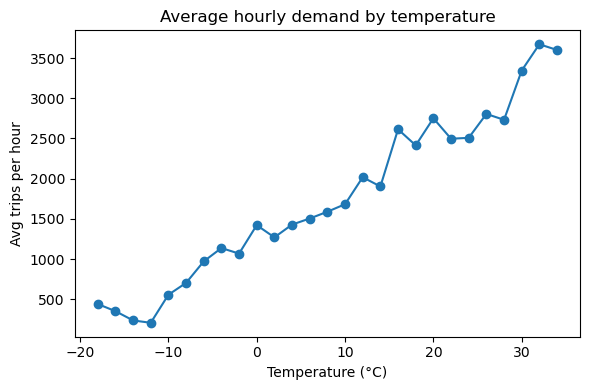

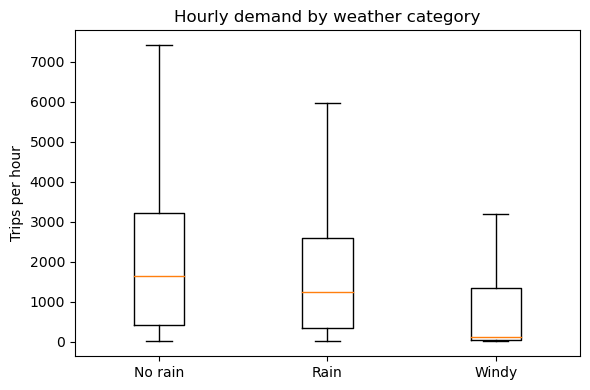

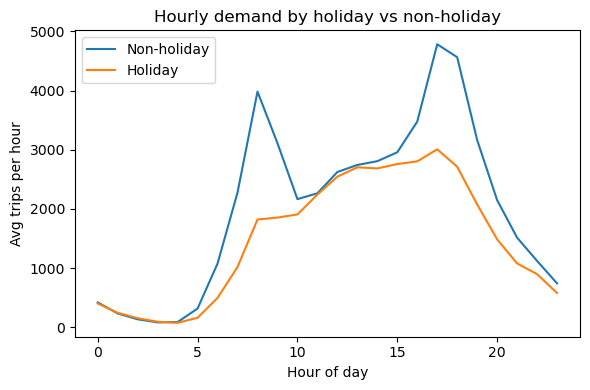

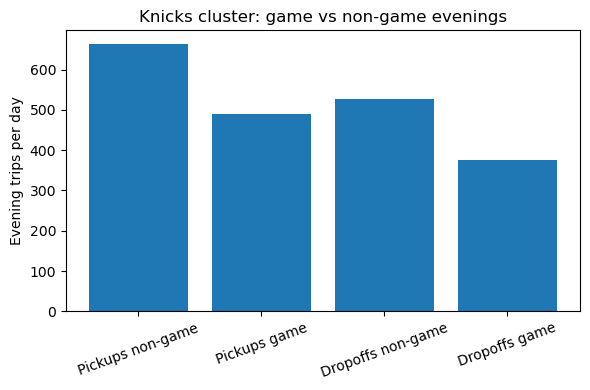

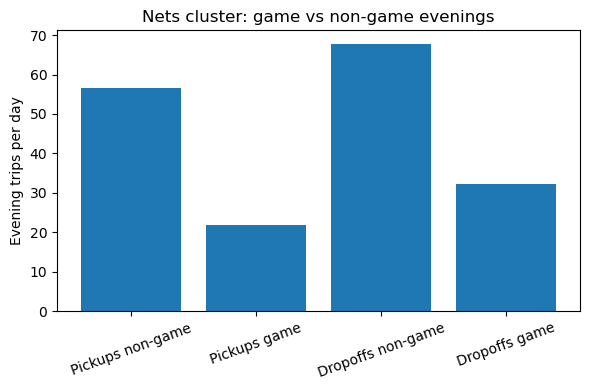

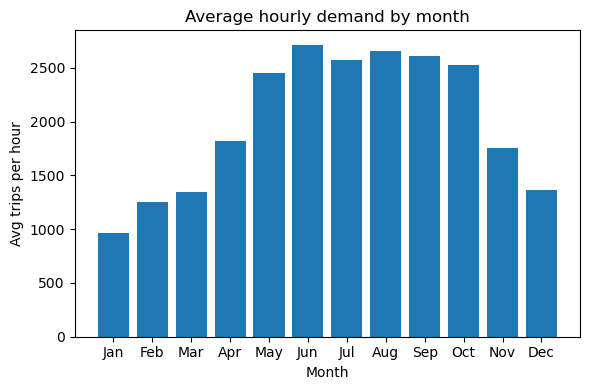

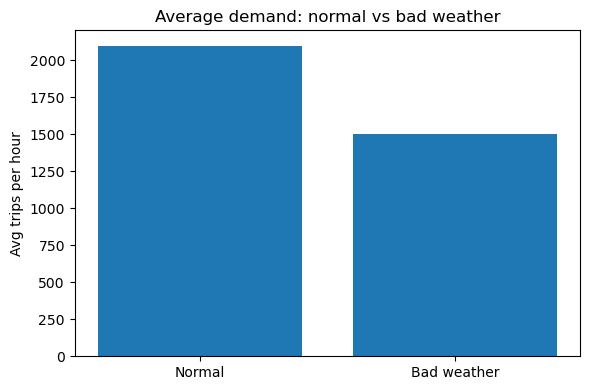

In [60]:
# Profile demand against temperature buckets.
profile_df = data.copy()

if profile_df["temp_C"].notna().any():
    temp_bins = np.arange(
        np.floor(profile_df["temp_C"].min()),
        np.ceil(profile_df["temp_C"].max()) + 1,
        2,
    )
    temp_profile = (
        profile_df.assign(temp_bin=pd.cut(profile_df["temp_C"], bins=temp_bins))
        .groupby("temp_bin")["trips_total"]
        .mean()
        .reset_index()
        .dropna()
    )
    bin_centers = temp_profile["temp_bin"].apply(lambda x: x.mid)
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, temp_profile["trips_total"], marker="o")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Avg trips per hour")
    plt.title("Average hourly demand by temperature")
    plt.tight_layout()
    plt.show()

# Categorize simple weather states and compare demand.
weather_category = pd.Series(index=profile_df.index, dtype="object")

is_rain = profile_df["rain_mm"] > 0
weather_category[is_rain] = "Rain"

wind_threshold = 30.0
is_windy = (~is_rain) & (profile_df["wind_kph"] >= wind_threshold)
weather_category[is_windy] = "Windy"

weather_category[weather_category.isna()] = "No rain"
profile_df["weather_cat"] = weather_category

weather_order = ["No rain", "Rain", "Windy"]
weather_groups = [
    profile_df.loc[profile_df["weather_cat"] == category, "trips_total"]
    for category in weather_order
]

plt.figure(figsize=(6, 4))
plt.boxplot(weather_groups, labels=weather_order, showfliers=False)
plt.ylabel("Trips per hour")
plt.title("Hourly demand by weather category")
plt.tight_layout()
plt.show()

hourly_profile = (
    profile_df.groupby(["is_holiday", "hour_of_day"])["trips_total"]
    .mean()
    .reset_index()
)
non_holiday = hourly_profile[hourly_profile["is_holiday"] == 0]
holiday = hourly_profile[hourly_profile["is_holiday"] == 1]

plt.figure(figsize=(6, 4))
plt.plot(non_holiday["hour_of_day"], non_holiday["trips_total"], label="Non-holiday")
if not holiday.empty:
    plt.plot(holiday["hour_of_day"], holiday["trips_total"], label="Holiday")
plt.xlabel("Hour of day")
plt.ylabel("Avg trips per hour")
plt.title("Hourly demand by holiday vs non-holiday")
plt.legend()
plt.tight_layout()
plt.show()

# Aggregate arena pickups/dropoffs for game-night comparisons.
def aggregate_hourly_dropoffs_arenas():
    counter = Counter()
    target_clusters = set(TEAM_CLUSTER.values())
    for chunk in pd.read_csv(
        trips_path,
        usecols=["stoptime", "end_station_id"],
        chunksize=400_000,
        low_memory=True,
    ):
        chunk["ts"] = pd.to_datetime(chunk["stoptime"], errors="coerce").dt.floor("H")
        chunk = chunk.dropna(subset=["ts", "end_station_id"])
        chunk["cluster_id"] = chunk["end_station_id"].astype("Int32").map(cluster_lookup)
        mask = chunk["cluster_id"].isin(target_clusters)
        if not mask.any():
            continue
        value_counts = chunk.loc[mask].groupby(["ts", "cluster_id"]).size()
        for (timestamp, cluster_id), count in value_counts.items():
            counter[(timestamp, int(cluster_id))] += int(count)

    df_dropoffs = pd.DataFrame(
        [(timestamp, cluster_id, count) for (timestamp, cluster_id), count in counter.items()],
        columns=["ts", "cluster_id", "dropoffs"],
    )
    df_dropoffs["date"] = df_dropoffs["ts"].dt.date
    df_dropoffs["hour"] = df_dropoffs["ts"].dt.hour
    return df_dropoffs.sort_values(["ts", "cluster_id"]).reset_index(drop=True)

df_hourly_drop = aggregate_hourly_dropoffs_arenas()

focus_pickups = df_hourly[df_hourly["cluster_id"].isin(TEAM_CLUSTER.values())].copy()
focus_pickups["team"] = np.where(
    focus_pickups["cluster_id"] == TEAM_CLUSTER["knicks"],
    "knicks",
    "nets",
)
focus_pickups_evening = focus_pickups[focus_pickups["hour"].between(18, 23)]

focus_dropoffs = df_hourly_drop[df_hourly_drop["cluster_id"].isin(TEAM_CLUSTER.values())].copy()
focus_dropoffs["team"] = np.where(
    focus_dropoffs["cluster_id"] == TEAM_CLUSTER["knicks"],
    "knicks",
    "nets",
)
focus_dropoffs_evening = focus_dropoffs[focus_dropoffs["hour"].between(18, 23)]

for team, cluster_id in TEAM_CLUSTER.items():
    game_dates = team_game_dates.get(team, set())

    daily_pickups = (
        focus_pickups_evening[focus_pickups_evening["cluster_id"] == cluster_id]
        .groupby("date")["pickups"]
        .sum()
    )
    daily_dropoffs = (
        focus_dropoffs_evening[focus_dropoffs_evening["cluster_id"] == cluster_id]
        .groupby("date")["dropoffs"]
        .sum()
    )

    game_mask_pickups = daily_pickups.index.isin(game_dates)
    game_mask_dropoffs = daily_dropoffs.index.isin(game_dates)

    game_pickups = daily_pickups[game_mask_pickups]
    non_game_pickups = daily_pickups[~game_mask_pickups]
    game_dropoffs = daily_dropoffs[game_mask_dropoffs]
    non_game_dropoffs = daily_dropoffs[~game_mask_dropoffs]

    if len(game_pickups) and len(non_game_pickups) and len(game_dropoffs) and len(non_game_dropoffs):
        values = [
            non_game_pickups.mean(),
            game_pickups.mean(),
            non_game_dropoffs.mean(),
            game_dropoffs.mean(),
        ]
        labels = [
            "Pickups non-game",
            "Pickups game",
            "Dropoffs non-game",
            "Dropoffs game",
        ]
        plt.figure(figsize=(6, 4))
        plt.bar(labels, values)
        plt.ylabel("Evening trips per day")
        plt.title(f"{team.capitalize()} cluster: game vs non-game evenings")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

monthly_profile = (
    profile_df.groupby("month")["trips_total"]
    .mean()
    .reset_index()
)

monthly_profile["month_name"] = monthly_profile["month"].apply(lambda m: calendar.month_abbr[int(m)])

plt.figure(figsize=(6, 4))
plt.bar(monthly_profile["month_name"], monthly_profile["trips_total"])
plt.xlabel("Month")
plt.ylabel("Avg trips per hour")
plt.title("Average hourly demand by month")
plt.tight_layout()
plt.show()

cold = profile_df["temp_C"] <= 0
wet = profile_df["rain_mm"] > 0
windy = profile_df["wind_kph"] >= wind_threshold
cloudy = profile_df["cloudcover"] >= 80

bad_score = cold.astype(int) + wet.astype(int) + windy.astype(int) + cloudy.astype(int)
profile_df["bad_weather"] = (bad_score >= 2).astype("int8")

bad_profile = (
    profile_df.groupby("bad_weather")["trips_total"]
    .mean()
    .reset_index()
)

labels = ["Normal", "Bad weather"]
values = [
    bad_profile.loc[bad_profile["bad_weather"] == 0, "trips_total"].iloc[0],
    bad_profile.loc[bad_profile["bad_weather"] == 1, "trips_total"].iloc[0],
]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel("Avg trips per hour")
plt.title("Average demand: normal vs bad weather")
plt.tight_layout()
plt.show()


### 3.7 Game-day uplift vs nearby non-game days

Compare each NBA game day to the nearest same-type (weekday/weekend) non-game day before and after, using full-day pickups.

In [61]:
# Compare each game day to nearby non-game days with same weekend flag.
neighbor_count = 1
uplift_rows = []

for team, cluster_id in TEAM_CLUSTER.items():
    game_dates = sorted(team_game_dates.get(team, set()))
    daily_pickups = (
        focus_pickups[focus_pickups["cluster_id"] == cluster_id]
        .groupby("date")["pickups"]
        .sum()
        .rename("pickups")
        .reset_index()
    )
    daily_pickups["date"] = pd.to_datetime(daily_pickups["date"])
    daily_pickups["is_weekend"] = daily_pickups["date"].dt.dayofweek >= 5
    daily_pickups["is_game"] = daily_pickups["date"].dt.date.isin(game_dates)

    for game_date in game_dates:
        game_row = daily_pickups.loc[daily_pickups["date"].dt.date == game_date]
        if game_row.empty:
            continue

        is_weekend = game_row["is_weekend"].iloc[0]
        game_pickups = float(game_row["pickups"].iloc[0])

        candidates = daily_pickups[
            (~daily_pickups["is_game"]) & (daily_pickups["is_weekend"] == is_weekend)
        ].copy()

        before = candidates[candidates["date"] < pd.Timestamp(game_date)].sort_values("date")
        after = candidates[candidates["date"] > pd.Timestamp(game_date)].sort_values("date")
        neighbors = pd.concat([before.tail(neighbor_count), after.head(neighbor_count)])
        if neighbors.empty:
            continue

        baseline = neighbors["pickups"].mean()
        uplift_rows.append({
            "team": team,
            "game_date": game_date,
            "is_weekend": bool(is_weekend),
            "game_pickups": game_pickups,
            "baseline_pickups": float(baseline),
            "uplift": float(game_pickups - baseline),
            "neighbors_used": len(neighbors),
        })

uplift_df = pd.DataFrame(uplift_rows)

if not uplift_df.empty:
    summary = (
        uplift_df.groupby("team")
        .agg(
            total_uplift=("uplift", "sum"),
            games_covered=("game_date", "nunique"),
            avg_uplift_per_game=("uplift", "mean"),
        )
        .reindex(["knicks", "nets"])
        .dropna(how="all")
    )
    print(summary.round(1))


        total_uplift  games_covered  avg_uplift_per_game
team                                                    
knicks          93.5             39                  2.4
nets           -41.5             45                 -0.9


### 3.8 RF feature importance

Check which features the baseline random forest thinks matter most.

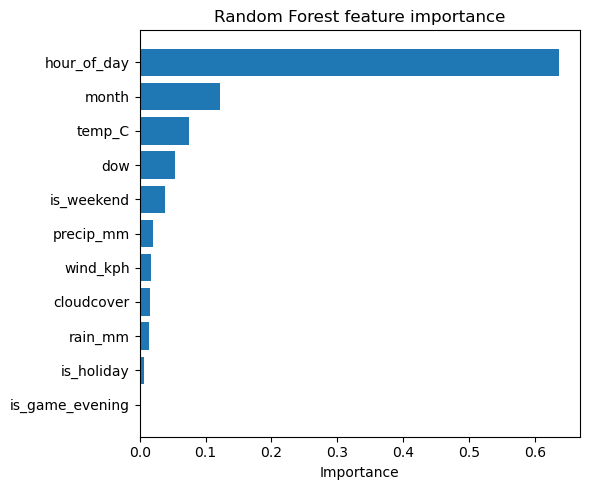

In [62]:
# Plot random forest feature importances (team flags dropped for clarity).
importances = pd.Series(rf.feature_importances_, index=feature_cols)

plot_importances = importances.drop(["is_knicks_evening", "is_nets_evening"],errors="ignore",).sort_values()

plt.figure(figsize=(6, 5))
plt.barh(plot_importances.index, plot_importances.values)
plt.xlabel("Importance")
plt.title("Random Forest feature importance")
plt.tight_layout()
plt.show()


### 3.9 Baseline RF predictions

Train a first random forest model and look at its predictions for the first two weeks citywide.

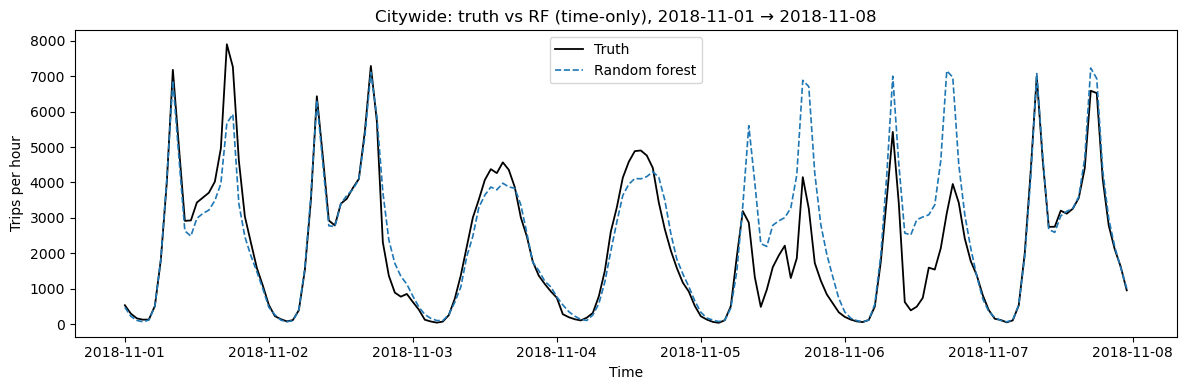

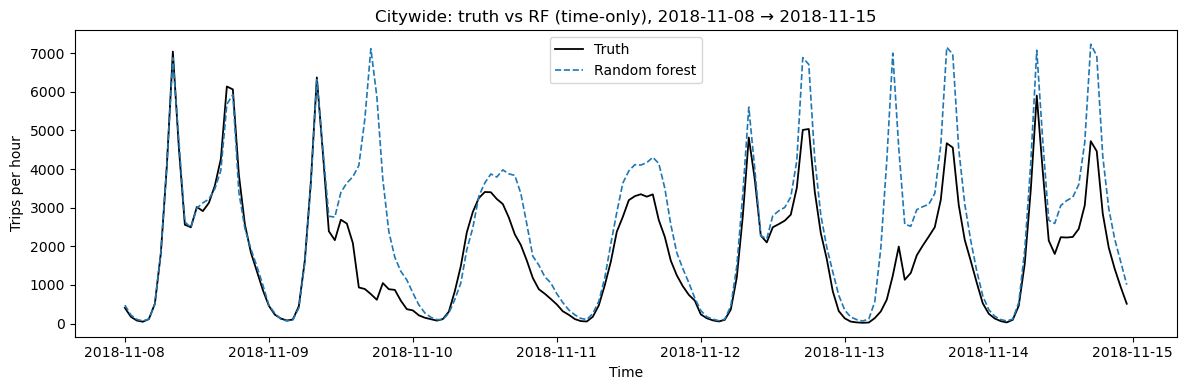

In [63]:
# Baseline random forest using only calendar features.
from sklearn.ensemble import RandomForestRegressor

BASE_FEATURES = ["dow", "hour_of_day", "month", "is_weekend"]

rf_base = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
)

rf_base.fit(train_df[BASE_FEATURES], train_df["trips_total"])

test_df["y_hat_rf_base"] = rf_base.predict(test_df[BASE_FEATURES])

TRUTH_STYLE = {"color": "black", "linewidth": 1.3, "label": "Truth"}
RF_BASE_STYLE = {"color": "tab:blue", "linestyle": "--", "linewidth": 1.2}
RF_FULL_STYLE = {"color": "tab:orange", "linestyle": "--", "linewidth": 1.2}

week1_start = pd.Timestamp("2018-11-01")
week1_end   = week1_start + pd.Timedelta(days=7)
week2_start = week1_end
week2_end   = week2_start + pd.Timedelta(days=7)

# Helper to visualize truth vs predictions over sample weeks.
def plot_citywide_week(df, pred_col, start, end, title_suffix):
    mask = (df["ts"] >= start) & (df["ts"] < end)
    w = df.loc[mask].set_index("ts")
    plt.figure(figsize=(12, 4))
    plt.plot(w.index, w["trips_total"], **TRUTH_STYLE)
    plt.plot(w.index, w[pred_col], label="Random forest", **RF_BASE_STYLE)
    plt.xlabel("Time")
    plt.ylabel("Trips per hour")
    plt.title(title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_citywide_week(
    test_df,
    "y_hat_rf_base",
    week1_start,
    week1_end,
    "Citywide: truth vs RF (time-only), 2018-11-01 → 2018-11-08",
)
plot_citywide_week(
    test_df,
    "y_hat_rf_base",
    week2_start,
    week2_end,
    "Citywide: truth vs RF (time-only), 2018-11-08 → 2018-11-15",
)


### 3.10 Enhanced RF with exogenous features

Add richer weather, holiday, and event features to the random forest, then inspect how the upgraded model tracks the first two weeks.

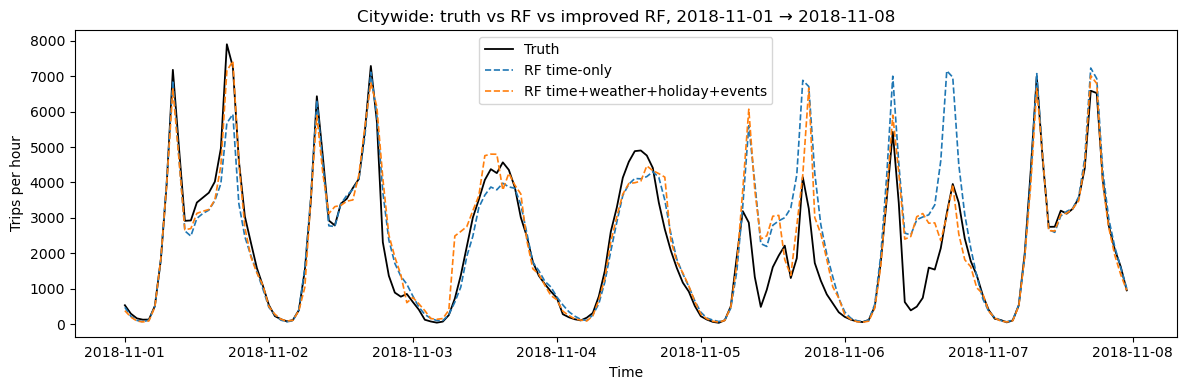

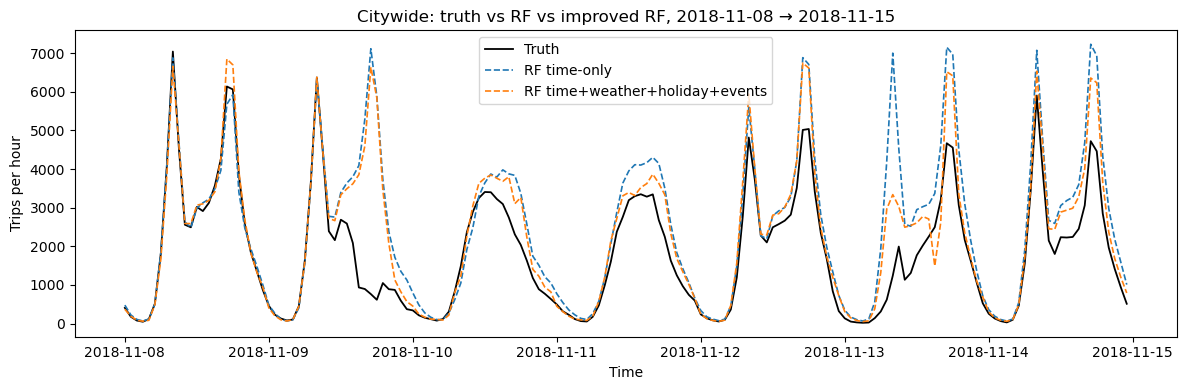

In [64]:
# Add composite bad-weather flag and expanded feature set.
wind_threshold = 30.0

def add_bad_weather_flag(df):
    cold = df["temp_C"] <= 0
    wet = df["rain_mm"] > 0
    windy = df["wind_kph"] >= wind_threshold
    cloudy = df["cloudcover"] >= 80
    score = cold.astype(int) + wet.astype(int) + windy.astype(int) + cloudy.astype(int)
    df["bad_weather"] = (score >= 2).astype("int8")
    return df

train_df = add_bad_weather_flag(train_df)
test_df  = add_bad_weather_flag(test_df)

EXTRA_FEATURES = [
    "temp_C",
    "precip_mm",
    "rain_mm",
    "wind_kph",
    "cloudcover",
    "is_holiday",
    "bad_weather",
    "is_game_evening",
]

FULL_FEATURES = BASE_FEATURES + EXTRA_FEATURES

# Fit enhanced RF with weather/holiday/event signals.
rf_full = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
)

rf_full.fit(train_df[FULL_FEATURES], train_df["trips_total"])

test_df["y_hat_rf_full"] = rf_full.predict(test_df[FULL_FEATURES])

# Plot truth vs both models over sample weeks.
def plot_citywide_week_multi(df, start, end, title_suffix):
    mask = (df["ts"] >= start) & (df["ts"] < end)
    w = df.loc[mask].set_index("ts")
    plt.figure(figsize=(12, 4))
    plt.plot(w.index, w["trips_total"], **TRUTH_STYLE)
    plt.plot(w.index, w["y_hat_rf_base"], label="RF time-only", **RF_BASE_STYLE)
    plt.plot(w.index, w["y_hat_rf_full"], label="RF time+weather+holiday+events", **RF_FULL_STYLE)
    plt.xlabel("Time")
    plt.ylabel("Trips per hour")
    plt.title(title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_citywide_week_multi(
    test_df,
    week1_start,
    week1_end,
    "Citywide: truth vs RF vs improved RF, 2018-11-01 → 2018-11-08",
)
plot_citywide_week_multi(
    test_df,
    week2_start,
    week2_end,
    "Citywide: truth vs RF vs improved RF, 2018-11-08 → 2018-11-15",
)


### 3.11 Quantify improvements

Report metrics for the improved model to see the gain over the baseline.

In [65]:
# Compare base vs enhanced model metrics on the Nov–Dec test window.
def eval_from_predcol(df, pred_col):
    tmp = df.copy()
    tmp["y_hat"] = tmp[pred_col]
    return metrics(tmp)

print("Test metrics (Nov–Dec 2018):")

m_base = {k: round(v, 3) for k, v in eval_from_predcol(test_df, "y_hat_rf_base").items()}
print("  RF time-only:", m_base)

m_full = {k: round(v, 3) for k, v in eval_from_predcol(test_df, "y_hat_rf_full").items()}
print("  RF time+weather+holiday+events:", m_full)


Test metrics (Nov–Dec 2018):
  RF time-only: {'MAE': 976.927, 'RMSE': 1501.698, 'WAPE': 0.628, 'MAPE_pct': 129.823}
  RF time+weather+holiday+events: {'MAE': 721.96, 'RMSE': 1165.953, 'WAPE': 0.464, 'MAPE_pct': 90.546}


### 3.12 Use KMeans clusters

Reuse the KMeans clusters to break down predictions by area.

In [66]:
# Prepare cluster-level frame for two target clusters.
target_clusters = [0, 6]

cluster_df = df_hourly[df_hourly["cluster_id"].isin(target_clusters)].copy()

cluster_df = cluster_df.merge(weather, on="ts", how="left")
cluster_df["date"] = cluster_df["ts"].dt.date
cluster_df["dow"] = cluster_df["ts"].dt.dayofweek.astype("int8")
cluster_df["hour_of_day"] = cluster_df["ts"].dt.hour.astype("int8")
cluster_df["month"] = cluster_df["ts"].dt.month.astype("int8")
cluster_df["is_weekend"] = (cluster_df["dow"] >= 5).astype("int8")

cluster_df = cluster_df.merge(holidays_2018[["date", "is_holiday"]], on="date", how="left")
cluster_df["is_holiday"] = cluster_df["is_holiday"].fillna(0).astype("int8")

cluster_df["is_knicks_evening"] = (
    cluster_df["date"].isin(team_game_dates.get("knicks", set()))
    & cluster_df["hour_of_day"].between(18, 23)
).astype("int8")

cluster_df["is_nets_evening"] = (
    cluster_df["date"].isin(team_game_dates.get("nets", set()))
    & cluster_df["hour_of_day"].between(18, 23)
).astype("int8")

cluster_df["is_game_evening"] = (
    cluster_df[["is_knicks_evening", "is_nets_evening"]].max(axis=1)
).astype("int8")

wind_threshold = 30.0
cold = cluster_df["temp_C"] <= 0
wet = cluster_df["rain_mm"] > 0
windy = cluster_df["wind_kph"] >= wind_threshold
cloudy = cluster_df["cloudcover"] >= 80
bad_score = cold.astype(int) + wet.astype(int) + windy.astype(int) + cloudy.astype(int)
cluster_df["bad_weather"] = (bad_score >= 2).astype("int8")

# Split cluster-level data into train/test around Nov 1.
cluster_train_mask = cluster_df["ts"] < pd.Timestamp("2018-11-01")
cluster_train = cluster_df.loc[cluster_train_mask].copy()
cluster_test = cluster_df.loc[~cluster_train_mask].copy()

print("Clusters in frame:", sorted(cluster_df["cluster_id"].unique()))
print("Train rows:", len(cluster_train), "| Test rows:", len(cluster_test))


Clusters in frame: [0, 6]
Train rows: 14253 | Test rows: 2878


### 3.13 Cluster 0 vs 6 runs

Repeat the modeling and plots for two example clusters to compare patterns.

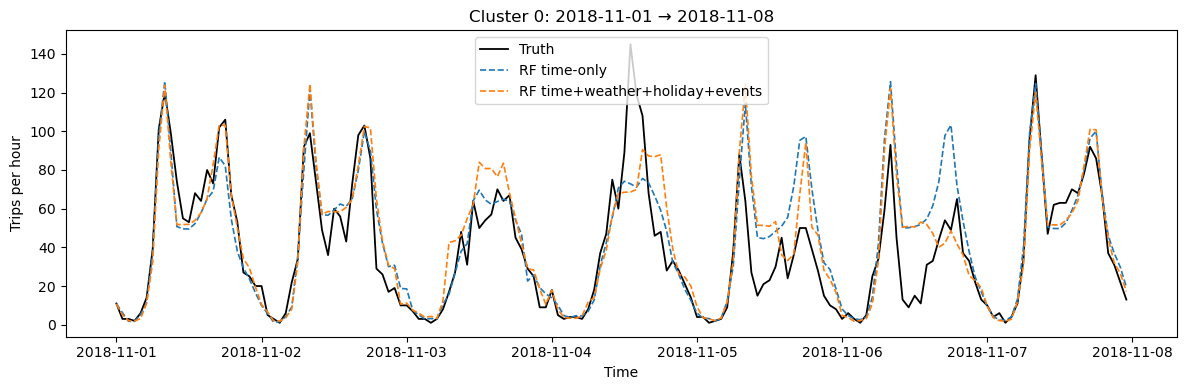

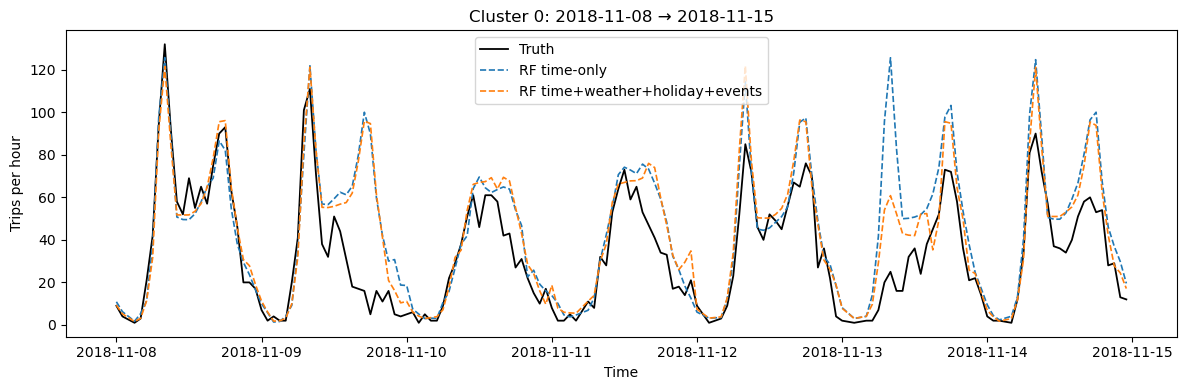

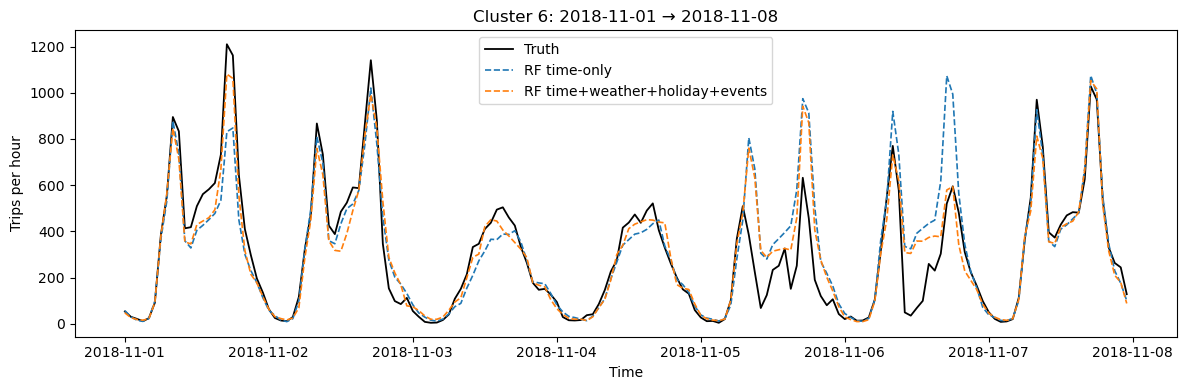

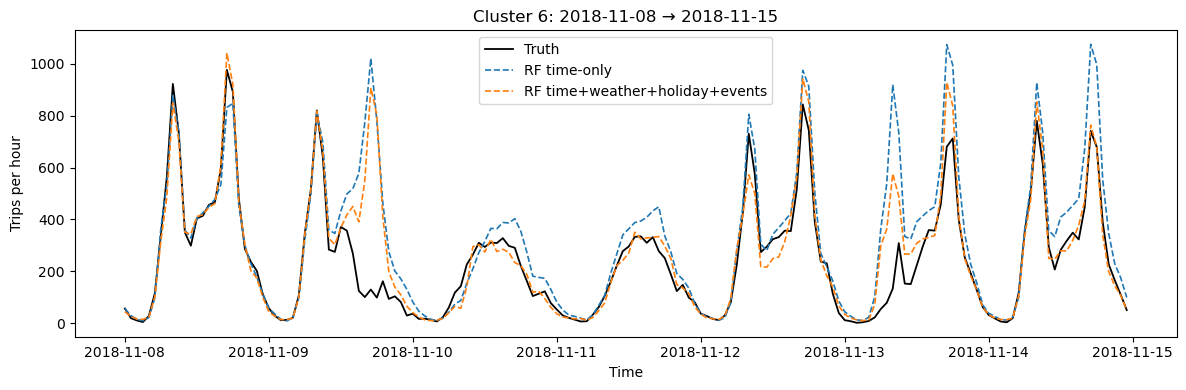

In [67]:
# Train baseline and enhanced RF models per cluster.
BASE_FEATURES = ["dow", "hour_of_day", "month", "is_weekend"]

EXTRA_FEATURES = [
    "temp_C",
    "precip_mm",
    "rain_mm",
    "wind_kph",
    "cloudcover",
    "is_holiday",
    "bad_weather",
    "is_game_evening",
]

FULL_FEATURES = BASE_FEATURES + EXTRA_FEATURES

cluster_models = {}

for cluster_id in target_clusters:
    train_c = cluster_train[cluster_train["cluster_id"] == cluster_id].copy()
    test_c = cluster_test[cluster_test["cluster_id"] == cluster_id].copy()
    rf_base = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1,
    )
    rf_base.fit(train_c[BASE_FEATURES], train_c["pickups"])
    test_c["y_hat_rf_base"] = rf_base.predict(test_c[BASE_FEATURES])
    rf_full = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1,
    )
    rf_full.fit(train_c[FULL_FEATURES], train_c["pickups"])
    test_c["y_hat_rf_full"] = rf_full.predict(test_c[FULL_FEATURES])
    cluster_models[cluster_id] = {
        "train": train_c,
        "test": test_c,
        "rf_base": rf_base,
        "rf_full": rf_full,
    }

week1_start = pd.Timestamp("2018-11-01")
week1_end = week1_start + pd.Timedelta(days=7)
week2_start = week1_end
week2_end = week2_start + pd.Timedelta(days=7)

# Plot two sample weeks for each cluster.
def plot_cluster_week(cluster_id, week_start, week_end, title_suffix):
    test_c = cluster_models[cluster_id]["test"]
    mask = (test_c["ts"] >= week_start) & (test_c["ts"] < week_end)
    w = test_c.loc[mask].set_index("ts")
    plt.figure(figsize=(12, 4))
    plt.plot(w.index, w["pickups"], **TRUTH_STYLE)
    plt.plot(w.index, w["y_hat_rf_base"], label="RF time-only", **RF_BASE_STYLE)
    plt.plot(w.index, w["y_hat_rf_full"], label="RF time+weather+holiday+events", **RF_FULL_STYLE)
    plt.xlabel("Time")
    plt.ylabel("Trips per hour")
    plt.title(title_suffix)
    plt.legend()
    plt.tight_layout()
    plt.show()

for cluster_id in target_clusters:
    plot_cluster_week(
        cluster_id,
        week1_start,
        week1_end,
        f"Cluster {cluster_id}: 2018-11-01 → 2018-11-08",
    )
    plot_cluster_week(
        cluster_id,
        week2_start,
        week2_end,
        f"Cluster {cluster_id}: 2018-11-08 → 2018-11-15",
    )


### 3.14 Cluster-level metrics

Summarize metrics for the cluster-specific runs to gauge performance.

In [68]:
# Report cluster-level error metrics for pickups.
def cluster_metrics(df, target_col, pred_col):
    y = df[target_col].to_numpy(dtype="float64")
    y_hat = df[pred_col].to_numpy(dtype="float64")
    error = y - y_hat
    mae = float(np.mean(np.abs(error)))
    rmse = float(np.sqrt(np.mean(error**2)))
    wape = float(np.sum(np.abs(error)) / max(1e-9, np.sum(np.abs(y))))
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape}

print("Test metrics per cluster (Nov.Dec 2018):")

for cluster_id in target_clusters:
    test_c = cluster_models[cluster_id]["test"]
    base_metrics = {
        k: round(v, 3)
        for k, v in cluster_metrics(test_c, "pickups", "y_hat_rf_base").items()
    }
    full_metrics = {
        k: round(v, 3)
        for k, v in cluster_metrics(test_c, "pickups", "y_hat_rf_full").items()
    }
    print(f"Cluster {cluster_id}:")
    print("  RF time-only:", base_metrics)
    print("  RF time+weather+holiday+events:", full_metrics)


Test metrics per cluster (Nov.Dec 2018):
Cluster 0:
  RF time-only: {'MAE': 17.867, 'RMSE': 25.764, 'WAPE': 0.616}
  RF time+weather+holiday+events: {'MAE': 15.955, 'RMSE': 22.851, 'WAPE': 0.55}
Cluster 6:
  RF time-only: {'MAE': 117.54, 'RMSE': 193.432, 'WAPE': 0.556}
  RF time+weather+holiday+events: {'MAE': 70.026, 'RMSE': 123.096, 'WAPE': 0.331}
